# Modeling marsh herbivor effects on marsh surviability.

*(modified from Greg Tucker, August 2020)*

This tutorial takes the parts that have previously been demonstrated in the marsh grass herbivory and tidal_flow_with_veg tutorials.  We will use the herbivory of the agent based model to augment the pymm2d vegetation matrix which subsequently drives the roughness calculations in the tidalFlowCalculator. 

# Creating the domain

Previously we have made an numerically generated domain for the purposes of the example. However, we will now import a digital elevation model (DEM), in .asc format, to act as the basis of our Landlab model grid.

In [1]:
# imports
import numpy as np
from tqdm import tqdm
import rasterio as rio
from landlab.io import read_esri_ascii
import os
from landlab import RasterModelGrid, imshow_grid



Currently the DEM specifies a "no data" paramter as -9999 so we will apply that to your model as well.

In [2]:
grid_raster = 'Gull_Island_mini_10meter_units_meters.asc' # import DEM

(grid, topo) = read_esri_ascii(grid_raster, name='topographic__elevation') # setup topographic elevation and grid
topo[topo == -9999] = np.nan # -9999 was used as the 'na' indictor when the DEM was generated. 
grid.set_nodata_nodes_to_closed(topo, -9999)


# Setup the model domain

It is necessary to setup a model domain to control where erodable areas exist in the model and where unerodible area exist. We also use the "grid.set_closed_boundaries_at_grid_edges" to define areas that are closed to tidal flow. This will limit the domain edgest that tidalFlowCalculator will use for its calculations. 

In [3]:
print(topo.shape)
model_domain = np.copy(topo)
model_domain[:] = 1

##################################
# grid boundaries
grid.set_closed_boundaries_at_grid_edges(right_is_closed=True,
                                               top_is_closed=True,
                                               left_is_closed=True,
                                               bottom_is_closed=False)


def complete_domain(model_domain):
    checkDomain = np.reshape(model_domain, grid.shape)
    domainIndex = np.reshape(range(0,len(model_domain)), grid.shape)
    if len(checkDomain[checkDomain[:,0] == 2]) == len(checkDomain[:,0])-2:
        print("The model is open along the left edge")
        checkDomain[:,0] = 2
    if len(checkDomain[checkDomain[:,-1] == 2]) == len(checkDomain[:,-1])-2:
        print("The model is open along the Right edge")
        checkDomain[:,-1] = 2
    updated_bndry_nodes = domainIndex[checkDomain ==2]
    return(checkDomain, updated_bndry_nodes)


(3172,)


We previously showed that no data areas were listed as -9999 and will be ignored in the model. We can also purposefully set areas to "closed" areas where nothing can flow or be eroded. This is useful if you have boundaries that 

In [4]:
model_domain, bndryNodes = complete_domain(model_domain)
boundaryTopo = topo.flatten()[bndryNodes]
model_domain[bndryNodes] = 2 # set boundary nodes to NA

# Test RSLR senarios 

MarshMorpho2D allows for testing different sea level rise rates. We have coded a function with three Realtive Sea Level Rise (RSLR) senarios that are predicted by USACE. We can toggle a hyper parameter "senario" between "High", "Medium", and "Low" to look at how marshes will survive differently. 

In [5]:
####### RSLR scenarios ######################################################################
def USACE_SLR_Senarios(senario, rnd):
    # this assumes a starting year of 2020
    x = rnd + 2020
    if senario == 'High':
        y = (-4.11*10**-3)*x**2 + 17.049*x - 17661
    elif senario == 'Medium':
        y = (-2.5644*10**-3)*x**2 + 10.639*x - 11022
    else:
        y = ((-1.3623*10**-3)*x**2 + 5.6493*x - 5847.5)
    return(y) # this is the predicted slr in mm. The above equations are already in mm
############################################################################################

# Setup herbivory

We will use the agent based random herbivory model from the marsh grass herbivory example to drive biomass reduction. Grazed vegetation will have lower roughness values and will be subject to reduced accretion. To do this we have modified the MarshMorpho2D script to accept the hervibory function. Vegetation coverage is calculated by the Coastal Wetland Equilibrium Model. The resulting area is then augmented by grazing before being sent to the roughness calculator.

In [6]:
from collections import defaultdict

from mesa import Agent
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivationByType
from typing import Callable, Optional, Type
from mesa import Model


def generate_grass_map(model):
    grass_map = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, (x, y) = cell
        for agent in cell_content:
            if type(agent) is GrassPatch:
                grass_map[x][y] = agent.biomass

    return grass_map



class RandomActivationByTypeFiltered(RandomActivationByType):
    """
    A scheduler that overrides the get_type_count method to allow for filtering
    of agents by a function before counting.

    Example:
    >>> scheduler = RandomActivationByTypeFiltered(model)
    >>> scheduler.get_type_count(AgentA, lambda agent: agent.some_attribute > 10)
    """

    def get_type_count(
        self,
        type_class: Type[Agent],
        filter_func: Optional[Callable[[Agent], bool]] = None,
    ) -> int:
        """
        Returns the current number of agents of certain type in the queue
        that satisfy the filter function.
        """
        if type_class not in self.agents_by_type:
            return 0
        count = 0
        for agent in self.agents_by_type[type_class].values():
            if filter_func is None or filter_func(agent):
                count += 1
        return count

class RandomWalker(Agent):
    """
    Class implementing random walker methods in a generalized manner.

    Not indended to be used on its own, but to inherit its methods to multiple
    other agents.

    """

    grid = None
    x = None
    y = None
    moore = True

    def __init__(self, unique_id, model, moore=True):
        """
        grid: The MultiGrid object in which the agent lives.
        x: The agent's current x coordinate
        y: The agent's current y coordinate
        moore: If True, may move in all 8 directions.
                Otherwise, only up, down, left, right.
        """
        super().__init__(unique_id, model)
        self.moore = moore

    def random_move(self):
        """
        Step one cell in any allowable direction.
        """
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = self.random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)


class Herbivore(RandomWalker):
    """
    A herbivore that walks around, reproduces (asexually) and eats grass.

    The init is the same as the RandomWalker.
    """

    energy = None

    def __init__(self, unique_id, model, moore, energy=None, food_preference=400):
        #Herbivore(self.next_id(), (x, y), self, True, energy)
        super().__init__(unique_id, model, moore=moore)
        self.energy = energy
        self.food_preference = food_preference

    def step(self):
        """
        A model step. Move, then eat grass and reproduce.
        """
        self.random_move()
        living = True

        if self.model.grass:
            # Reduce energy
            self.energy -= 15

            # If there is grass available, eat it
            this_cell = self.model.grid.get_cell_list_contents([self.pos])
            grass_patch = [obj for obj in this_cell if isinstance(obj, GrassPatch)][0]
            if grass_patch.biomass > self.food_preference:
                self.energy += self.model.herbivore_gain_from_food
                grass_patch.fully_grown = False
                grass_patch.biomass -= self.model.grass_loss_from_grazing

            # Death
            if self.energy < 0:
                # self.model.grid._remove_agent(self.pos, self)
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
                living = False

        if living and self.random.random() < self.model.herbivore_reproduce:
            # Create a new sheep:
            if self.model.grass:
                self.energy /= 2
            juvenile = Herbivore(
                self.model.next_id(), self.model, self.moore, self.energy, self.food_preference
            )
            self.model.grid.place_agent(juvenile, self.pos)
            self.model.schedule.add(juvenile)


class GrassPatch(Agent):
    """
    A patch of grass that grows at a fixed rate and it is eaten by an herbivore
    """

    def __init__(self, unique_id, model, fully_grown, countdown, max_biomass):
        """
        Creates a new patch of grass

        Args:
            grown: (boolean) Whether the patch of grass is fully grown or not
            countdown: Time for the patch of grass to be fully grown again
        """
        super().__init__(unique_id, model)
        self.countdown = countdown
        self.fully_grown = True #fully_grown
        self.max_biomass = max_biomass
        if self.fully_grown:
            self.percent_of_max = 1.0
            self.biomass = max_biomass
        else:
            self.percent_of_max =  (self.model.grass_regrowth_time - self.countdown) / self.model.grass_regrowth_time
            self.biomass = self.percent_of_max * self.max_biomass     
        

    def step(self):
        if not self.fully_grown:
            if self.countdown <= 0:
                self.fully_grown = True
                self.countdown = self.model.grass_regrowth_time
                self.percent_of_max = 1
                self.biomass = self.max_biomass
            else:
                self.percent_of_max = (self.model.grass_regrowth_time - self.countdown) / self.model.grass_regrowth_time
                self.biomass = self.percent_of_max * self.max_biomass
                self.countdown -= 1



"""
Wolf-Sheep Predation Model
================================

Replication of the model found in NetLogo:
    Wilensky, U. (1997). NetLogo Wolf Sheep Predation model.
    http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation.
    Center for Connected Learning and Computer-Based Modeling,
    Northwestern University, Evanston, IL.
"""


class HerbivoreGrass(Model):
    """
    Herbivore Grass Model
    """

    # height = 20
    # width = 20

    initial_herbivores = 10

    herbivore_reproduce = 0.04

    grass = False
    grass_regrowth_time = 30
    herbivore_gain_from_food = 4

    verbose = False  # Print-monitoring

    description = (
        "A model for simulating wolf and sheep (predator-prey) ecosystem modelling."
    )

    def __init__(
        self,
        initial_herbivores=100,
        herbivore_reproduce=0.02,
        grass=False,
        grass_regrowth_time=12,
        grass_loss_from_grazing=100,
        grass_max_biomass=700,
        herbivore_gain_from_food=50,
        verbose=False,
        gridShape = None
    ):
        """
        Create a new Wolf-Sheep model with the given parameters.

        Args:
            initial_sheep: Number of sheep to start with
            initial_wolves: Number of wolves to start with
            sheep_reproduce: Probability of each sheep reproducing each step
            wolf_reproduce: Probability of each wolf reproducing each step
            wolf_gain_from_food: Energy a wolf gains from eating a sheep
            grass: Whether to have the sheep eat grass for energy
            grass_regrowth_time: How long it takes for a grass patch to regrow
                                 once it is eaten
            herbivore_gain_from_food: Energy herbivore gain from grass, if enabled.
        """
        super().__init__(verbose=verbose)
        # Set parameters
        height, width = gridShape # we are modifying the grid creation to handled a spatial grid
        self.height = height
        self.width = width
        self.initial_herbivores = initial_herbivores
        self.herbivore_reproduce = herbivore_reproduce
        self.grass = grass
        self.grass_regrowth_time = grass_regrowth_time
        self.grass_loss_from_grazing = grass_loss_from_grazing
        self.herbivore_gain_from_food = herbivore_gain_from_food
        self.verbose = verbose

        self.schedule = RandomActivationByTypeFiltered(self)
        self.grid = MultiGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
            {
                "Herbivores": lambda m: m.schedule.get_type_count(Herbivore),
                "Grass": lambda m: m.schedule.get_type_count(
                    GrassPatch, lambda x: x.biomass
                ),
            }
        )

        # Create herbivores:
        for i in range(self.initial_herbivores):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            while x >= self.width -10: # added in while statement to restrict edge issues
                x = self.random.randrange(self.width)
            while y >= self.height -10:
                y = self.random.randrange(self.height)
            energy = self.random.randrange(2 * self.herbivore_gain_from_food)
            herbivore = Herbivore(
                self.next_id(), 
                self, 
                True, 
                energy,
                food_preference=350
                )
            self.schedule.add(herbivore)
            self.grid.place_agent(herbivore, (x, y))
            

        # Create grass patches
        if self.grass:
            for agent, (x, y) in self.grid.coord_iter():
                fully_grown = self.random.choice([True, False])

                if fully_grown:
                    countdown = self.grass_regrowth_time
                else:
                    countdown = self.random.randrange(self.grass_regrowth_time)

                patch = GrassPatch(self.next_id(), self, fully_grown, countdown, grass_max_biomass)
                self.schedule.add(patch)
                self.grid.place_agent(patch, (x, y))
                

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        if self.verbose:
            print(
                [
                    self.schedule.time,
                    self.schedule.get_type_count(Herbivore),
                ]
            )

    def run_model(self, step_count=200):
        if self.verbose:
            print("Initial number herbivores: ", self.schedule.get_type_count(Herbivore))

        for i in range(step_count):
            self.step()

        if self.verbose:
            print("")
            print("Final number herbivores: ", self.schedule.get_type_count(Herbivore))

# also add in the ability to plot the flow metrics.
def plot_tidal_flow(grid, resample=1):
    (ebb_x, ebb_y, flood_x, flood_y) = map_velocity_components_to_nodes(grid)

    # depth
    plt.figure()
    imshow_grid(
        grid, grid.at_node["mean_water__depth"], cmap="YlGnBu", color_for_closed="g"
    )
    plt.title("Water depth (m)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    # down-sample for legible quiver plots if needed
    if resample != 1:
        xr = grid.x_of_node.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        yr = grid.y_of_node.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        ebb_xr = ebb_x.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[
            ::resample, ::resample
        ]
        ebb_yr = ebb_y.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[
            ::resample, ::resample
        ]
        fld_xr = flood_x.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
        fld_yr = flood_y.reshape(
            (grid.number_of_node_rows, grid.number_of_node_columns)
        )[::resample, ::resample]
    else:
        xr = grid.x_of_node
        yr = grid.y_of_node
        ebb_xr = ebb_x
        ebb_yr = ebb_y
        fld_xr = flood_x
        fld_yr = flood_y

    # ebb tide
    plt.figure()
    imshow_grid(grid, grid.at_node["topographic__elevation"])
    plt.quiver(xr, yr, ebb_xr, ebb_yr)
    plt.title("Ebb Tide")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    ebb_vel_magnitude = np.sqrt(ebb_x * ebb_x + ebb_y * ebb_y)
    plt.figure()
    imshow_grid(grid, ebb_vel_magnitude, cmap="magma", color_for_closed="g")
    plt.title("Ebb Tide Velocity Magnitude (m/s)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    # flood tide
    plt.figure()
    imshow_grid(grid, grid.at_node["topographic__elevation"])
    plt.quiver(xr, yr, fld_xr, fld_yr)
    plt.title("Flood Tide")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    plt.figure()
    flood_vel_magnitude = np.sqrt(flood_x * flood_x + flood_y * flood_y)
    imshow_grid(grid, flood_vel_magnitude, cmap="magma", color_for_closed="g")
    plt.title("Flood Tide Velocity Magnitude (m/s)")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

# pymm2d integration
While it is a bit messy we are going to include the current python MM2D pacakge to show where we will be modifying the code. To integrate Mesa we will modify the final run statement to include a call to HerbivoreGrass function.

In [7]:
#! /usr/bin/env python
"""pyMarshMorpho2D model."""
import numpy as np
import pandas as pd
from landlab import Component
from landlab.components import TidalFlowCalculator
import math
import sys

np.set_printoptions(threshold=sys.maxsize)
import warnings
import scipy
from scipy import sparse
import numpy as np

warnings.filterwarnings("error")


class pymm2d(Component):
    """Simulate tidal marsh evolution."""

    _name = "pymm2d"

    _cite_as = """
    """

    _info = {
        "topographic__elevation": {
            "dtype": float,
            "intent": "inout",
            "optional": False,
            "units": "m",
            "mapping": "node",
            "doc": "Land surface topographic elevation",
        },
        "water_depth": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m",
            "mapping": "node",
            "doc": "Water depth",
        },
        "fully_wet__depth": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m",
            "mapping": "node",
            "doc": "Water depth, with depth > 0 everywhere",
        },
        "veg_is_present": {
            "dtype": bool,
            "intent": "out",
            "optional": False,
            "units": "-",
            "mapping": "node",
            "doc": "True where marsh vegetation is present",
        },
        "vegetation": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "?",
            "mapping": "node",
            "doc": "Some measure of vegetation...?",
        },
        "roughness": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "s/m^1/3",
            "mapping": "node",
            "doc": "Manning roughness coefficient",
        },
        "tidal_flow": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m/s",
            "mapping": "node",
            "doc": "half tidal range flow velocities",
        },
        "percent_time_flooded": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "percent",
            "mapping": "node",
            "doc": "The percent of a 24 hour day that the node is covered by water.",
        },
        "land_cover": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "percent",
            "mapping": "node",
            "doc": "The classified land cover of the marsh by the model. 0=water, 1=low marsh, 2=high marsh/uplands",
        },
        "land_cover_change": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "percent",
            "mapping": "node",
            "doc": "The classified land cover of the marsh by the model with the addition of areas that changed."
                   " 0=water, 1=low marsh, 2=high marsh/uplands, 3=change areas",
        },
        "accretion_over_time": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "percent",
            "mapping": "node",
            "doc": "Spatial map of marsh accretion over time"
        },
        "p_mask": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "percent",
            "mapping": "node",
            "doc": "Spatial map of masked out areas excluded from flow morphology calculations"
        },
        "a_mask": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "percent",
            "mapping": "node",
            "doc": "Spatial map of masked out areas excluded from flow morphology calculations after the q and parry gradient filters"
        },
    }

    def __init__(self, grid,
                 rel_sl_rise_rate=None,  # 4.0/1000/365,  # originally 2.74e-6
                 tidal_range = 1.2192,  # tidal range taken from Atlantic city NOAA tide gauge.
                 tidal_range_for_veg = 1.225296,
                 roughness_with_veg = 0.1,
                 roughness_without_veg = 0.02,
                 tidal_period = 12.5 / 24,
                 model_domain=None,
                 unit = None,
                 boundaryValues=None,
                 runMEM=None,
                 printAll=None
                 ):
        """Initialize the MarshEvolver.

        Parameters
        ----------
        grid : ModelGrid object
            Landlab model grid
        rel_sl_rise_rate : float
            Rate of relative sea-level rise, m/day
        tidal_range : float
            Tidal range, m
        tidal_range_for_veg : float
            Tidal range for vegetation model, m (normally same as tidal range)
        """

        super(pymm2d, self).__init__(grid)
        self.initialize_output_fields()

        # Get references to fields
        self._elev = self._grid.at_node['topographic__elevation']
        self._water_depth = self._grid.at_node['water_depth']
        self._fully_wet_depth = self._grid.at_node['fully_wet__depth']
        self._veg_is_present = self._grid.at_node['veg_is_present']
        self._vegetation = self._grid.at_node['vegetation']
        self._roughness = self._grid.at_node['roughness']
        self._tidal_flow = self._grid.at_node['tidal_flow']
        self._percent_time_flooded = self._grid.at_node['percent_time_flooded']
        self._boundaryValues = boundaryValues  # These are the topo values that boundary areas will be set back to at the end of a loop
        self._withMEM = runMEM

        # # apply roughness through hyperparameter
        # from landlab.grid.raster_mappers import map_mean_of_links_to_node
        # if roughness.any() != None:
        #     self._roughness = map_mean_of_links_to_node(grid, roughness)

        # Set parameter values
        self._mean_sea_level = 0  # m NAVD88
        self._elev_relative_to_MSL = self._elev - self._mean_sea_level
        self._rel_sl_rise_rate = rel_sl_rise_rate
        self._tidal_range = tidal_range
        self._tidal_range_for_veg = tidal_range_for_veg
        self._tidal_half_range = tidal_range / 2.0
        self._tidal_period = tidal_period  # this is the tidal period
        self._numberOfTidesPerYear = 365 / self._tidal_period  # get the number of tides in a year
        self._roughness_with_veg = roughness_with_veg
        self._roughness_without_veg = roughness_without_veg
        self._taucr = 0.2  # a user defined value as part of the mud paramaters in the original code it equals 0.2
        self._taucrVEG = 0.5  # a user defined value as aprt of the vegetation parameters "Critical Shear Stress for vegetated areas. The original value was 0.5
        self._me = 0.1 * pow(10,
                             -4) * 24 * 3600  # mud parameter per day *unsure exactly what this is but its part of the calucation for E
        self._wsB = 1 / 1000  # P.wsB=1/1000;#Mud Settling velocity for vegetated area
        self._ws2 = 0.2 / 1000  # P.ws2=0.2/1000;#0.2/1000;# m/s
        self._DoMUD = 1  # base diffusivity of suspended mud [m2/s]. Process not related to tides (e.g. wind and waves, other ocean circulation)
        self._Diffs = 1  # [-]coefficient for tidal dispersion [-]. 1 DO NOT CHANGE
        # self._tidal_period = tidal_period# 12.5/24 # tidal period [day]
        self._rhos = 2650  # sediment density(quartz - mica)[kg / m3]
        self._por2 = 0.7  # A user defined porocity value
        self._rbulk = self._rhos * (1 - self._por2)
        self._sea_SSC = 60 / 1000  # 40/1000; # Sea boundary SSC for mud [g/l]
        self._limitdeltaz = 2  # meters maximum erosion value
        self._limitmaxup = 1  # meters maximum deposition value
        self._min_water_depth = 0.2  # minimuim water depth
        self._suspended_sediment = 23  # 73.0 # suspended sediment concentration, mg/l
        self._accretion_over_time = np.zeros(self._grid.shape).flatten()  # logs the accretion over time
        self._KBTOT = 0  # something
        self._crMUD = 3.65 / 365  # creep coefficient
        self._alphaMUD = 0.25  # coefficient for bedload downslope of mud.added April 2019. Similar to P.alphaSAND
        self._crMARSH = 0.1 / 365  # creep coefficient vegetated
        self._unit = int(abs(self._grid.x_of_node[0] - self._grid.x_of_node[1]))# unit  # this is the spatial grid size or unit.
        self._printAll = printAll  # this is to toggle printing on or off. If printAll = None then no printing occures in regards to the "P" model solver.


        # lower and upper limits for veg growth [m]
        # see McKee, K.L., Patrick, W.H., Jr., 1988.
        # these are "dBlo" and "dBup" in matlab original
        self._min_elev_for_veg_growth = -(0.237 * self._tidal_range_for_veg
                                          - 0.092)
        self._max_elev_for_veg_growth = self._tidal_range_for_veg / 2.0

        # default model domain
        self._model_domain = np.reshape(model_domain, np.shape(self._elev))

        # setup index
        self._index = np.array(range(0, len(self._elev)))

    def exportSelfParam(self, saveLocation=None):
        import pandas as pd
        # this function prints/writes out the model settings
        print("Initial Model Parameters")
        print("-" * 60)
        print('\n')
        if saveLocation == None:  # Just print out the values
            for i in vars(self):
                try:
                    if len(vars(self)[i]) < 10:
                        print()
                except:
                    if i != "_grid":
                        print(f"    self.{i} = {vars(self)[i]}")
        else:
            att = []
            val = []
            for i in vars(self):
                try:
                    if len(vars(self)[i]) < 10:
                        print()
                except:
                    if i != "_grid":
                        att.append(''.join(['self.', str(i)]))
                        val.append(vars(self)[i])
                        print(f"    self.{i} = {vars(self)[i]}")
            hd = pd.DataFrame(zip(att, val), columns=["attribute_name", "value"])
            name = ''.join([saveLocation, '.csv'])
            print(f'Initial Model parameters have been exported to {name}')
            hd.to_csv(name)
        print("-" * 60)
        print('\n')

    def edgeEffects(self, arr):
        bndryNodes = (self._grid.closed_boundary_nodes)
        adjNodes = self._grid.adjacent_nodes_at_node[(bndryNodes)]

        # get the edge nodes and remove from consideration with boundary nodes.
        # this is meant to get all of the actual edge nodes and compare the model edge nodes.
        indexMatrix = np.reshape(self._index, self._grid.shape)
        edgeList = [indexMatrix[:,0], indexMatrix[:,-1], indexMatrix[0,:], indexMatrix[-1,:]]
        edgeNodes = []
        for e in edgeList:
            for val in e:
                edgeNodes.append(val)

        # fill the boundary node values with the mean value from adjacent nodes
        for i in range(len(bndryNodes)):
            idx = adjNodes[i]
            idx = idx[idx != -1]
            tf = np.in1d(idx, edgeNodes)
            idx = idx[tf == False]

            if bndryNodes[i] in edgeNodes:
                if len(idx) > 0:
                    arr[bndryNodes[i]] = np.mean(arr[idx])
                else:
                    # if no matcher exists the point has to be in a corner and needs to get the value on a diagonal.
                    # find the index value for corners
                    col, row = self._grid.shape
                    corners = [self._index[0], self._index[row - 1], self._index[(row * col) - row],
                               self._index[row * col - 1]]
                    replacementIndex = np.array(
                        [self._index[row + 1], self._index[row * 2 - 2], self._index[((col - 2) * row) + 1],
                         self._index[row * (col - 1) - 2]])
                    msk = np.array(np.in1d(corners, bndryNodes[i]))
                    idx = replacementIndex[msk]
                    try:
                        arr[bndryNodes[i]] = arr[idx][0]
                    except:
                        print(f'There was an issue with an unknown node {bndryNodes[i]}.')
        return (arr)

    def bedcreepponds(self, dx, dt):
        import numpy as np
        import scipy
        from scipy import sparse

        self._dx = dx
        self._dt = dt

        # matlab script function z=bedcreepponds(z,A,Active,Yreduction,crMUD,crMARSH,dx,dt,VEG,S,Qs,rbulk2,alphaMUD);
        # values bein input in original matlab script bedcreepponds(z, A, Active, A * 0 + 1, crMUD, crMARSH, dx, dt, VEG, S, Qs2, rbulk2, alphaMUD)
        self._Qs = self._Qs / self._rbulk

        Yreduction = (self._model_domain * 0) + 1

        creep = self._model_domain * 0
        creep[self._vegetation == 0] = self._crMUD + (self._alphaMUD * 3600 * 24 * self._Qs[self._vegetation == 0])
        creep[self._vegetation == 1] = self._crMARSH

        D = (creep) / (self._dx ** 2) * self._dt  # yreduction

        G = self._elev * 0
        p = np.where(self._model_domain == 1, True, False)
        G[p] = range(0, len(self._index[p]))  # self._index[p]
        rhs = self._elev[p]

        Spond = self._elev * 0

        # indexing methodology daken directory from the revious morphology steps
        N, M = self._grid.shape
        S = np.zeros((N * M))
        ilog = []
        jlog = []
        s = []

        # figure out this section
        for k in [N, -1, 1, -N]:  # calculate the gradianets between cells in the x and y direction
            # print(k)
            tmp = self._index[p].copy().astype(int)
            N, M = self._grid.shape
            row, col = np.unravel_index(tmp, shape=(N, M))  # sort this out.
            # indTemp = np.reshape(self._index, (N, M))
            if k == N:
                a = np.where(col + 1 < M, True, False)
                q = tmp + 1
            if k == -N:
                a = np.where(col - 1 >= 0, True, False)
                q = tmp - 1  # originally tmp was tmp[p]
            if k == -1:
                a = np.where(row - 1 >= 0, True, False)
                q = tmp - M
            if k == 1:
                a = np.where(row + 1 < N, True, False)
                q = tmp + M

            parray = tmp

            # 8-28-2023 updated logic to speed up processing
            ptmpArray = np.array(list(range(len(tmp))))[a]  # updated 9-29-2023
            cls = np.where(a[ptmpArray] == True, np.where(self._model_domain[q[a]] != -1, True, False), False)
            a[ptmpArray[cls]] = True
            a[ptmpArray[cls == False]] = False

            value = (D[parray[a]] + D[q[a]]) / 2
            value = value * np.minimum((Yreduction[parray[a]]), (Yreduction[q[a]]))

            # do not allow the edges of ponds to creep
            value[np.where(Spond[parray[a]] == 1, np.where(Spond[q[a]] == 0, True, False), False)] = 0
            value[np.where(Spond[parray[a]] == 0, np.where(Spond[q[a]] == 1, True, False), False)] = 0

            try:
                ilog = list(ilog) + list(G[q[a]].astype(int))
                jlog = list(jlog) + list(G[parray[a]].astype(int))
            except:
                print("There was an issue with ilog or jlog creation")
            # build a list of values exiting the node
            S[parray[a]] = S[parray[a]] + value
            s = list(s) + list(-value)
        ilog = list(ilog) + list(G[p].astype(int))
        jlog = list(jlog) + list(G[p].astype(int))
        # build a list of values exiting the node
        s = list(s) + list(1 + S[p])
        ds2 = sparse.csc_array((s, (ilog, jlog)))
        try:
            P = scipy.sparse.linalg.spsolve(ds2,
                                            rhs)  # was working with .lsqr # look into skcuda and cusparse to accelerate the model computation.
        except:
            if self._printAll != None:
                print("Bedcreep matrix solution was singular. Reverting to lsqr to solve matrix inversion")
            P = scipy.sparse.linalg.lsqr(ds2, rhs, iter_lim=5000)[0]
        zhld = self._elev.copy()
        zhld[:] = 0
        # zhld = np.zeros(self._elev)
        zhld[self._index[p]] = np.array(P)
        # zhld[np.isnan(zhld)] = 0
        # apply edge effect fix
        zhld = self.edgeEffects(zhld)
        return (zhld)

    def get_water_depth(self, min_depth=0.01):
        """Calculate the water depth field."""

        depth_at_mean_high_water = np.maximum((-self._elev)
                                              + self._mean_sea_level
                                              + self._tidal_half_range, 0.0)
        self._depth_at_mean_high_water = depth_at_mean_high_water  # record this value for later use
        self._fully_wet_depth = (0.5 * (depth_at_mean_high_water
                                        + np.maximum(depth_at_mean_high_water
                                                     - self._tidal_range, 0.0)))
        self._water_depth_ho = self._fully_wet_depth.copy()
        self._hydroperiod = np.minimum(1, np.maximum(0.001, (depth_at_mean_high_water / self._tidal_range)))
        self._fully_wet_depth[self._fully_wet_depth < min_depth] = min_depth
        self._water_depth[:] = self._fully_wet_depth
        self._water_depth[self._elev > (self._mean_sea_level + self._tidal_half_range)] = 0.0
        # self._water_depth[self._water_depth < self._min_water_depth] = self._min_water_depth
        hxxx = self._water_depth[self._water_depth < min_depth]
        relax = 10
        self._water_depth[self._water_depth < min_depth] = np.maximum(self._min_water_depth,
                                                                      min_depth * (1 - np.exp(-hxxx * relax)) / (
                                                                                  1 - np.exp(-min_depth * relax)))

    def update_flow(self):
        from landlab.grid.raster_mappers import map_mean_of_horizontal_links_to_node, map_mean_of_vertical_links_to_node
        from landlab.grid.mappers import map_mean_of_link_nodes_to_link
        from landlab.components import TidalFlowCalculator
        # from . import ERDC_TidalFlowCalculculator as flowCal
        """update the flow within the grid"""
        # you need to set the boundaries on the grid
        roughnessArray = map_mean_of_link_nodes_to_link(self._grid, self._roughness)
        # flood = flowCal.TidalFlowCalculator(self._grid, mean_sea_level=self._mean_sea_level,
        #                           tidal_range=self._tidal_range, tidal_period = self._tidal_period*24*3600,
        #                           roughness=roughnessArray, min_water_depth=0.1, scale_velocity=1)

        flood = TidalFlowCalculator(self._grid, mean_sea_level=self._mean_sea_level,
                                  tidal_range=self._tidal_range, tidal_period = self._tidal_period*24*3600,
                                  roughness=roughnessArray, min_water_depth=0.1, scale_velocity=1)
        flood.run_one_step()

        # tidal inundation time using Rober Hickey's method https://link.springer.com/article/10.1007/s11852-019-00690-2
        mhw = self._mean_sea_level + (self._tidal_range / 2)
        mlw = self._mean_sea_level - (self._tidal_range / 2)
        hld = 2 * (self._elev - mlw) / (mhw - mlw) - 1
        hld[hld > 1] = 1
        hld[hld < -1] = -1
        A = 2 * np.pi - np.arccos(hld)
        rising_time_over_cell = (self._tidal_period / 2 * 24) * (A / np.pi - 1)
        hld = 2 * (self._elev - mhw) / (mlw - mhw) - 1
        hld[hld > 1] = 1
        hld[hld < -1] = -1
        A = 2 * np.pi - np.arccos(hld)
        fall_time_over_cell = (self._tidal_period / 2 * 24) * (A / np.pi - 1)

        # calculate the number of hours in a day that the marsh surface is inundated.
        innundation_time = ((abs(rising_time_over_cell - (
                    self._tidal_period / 2 * 24)) + fall_time_over_cell)) * self._numberOfTidesPerYear  # / ((self._tidal_period * 24) / 24))
        self._percent_time_flooded = innundation_time / 8760 * 100  # inundation time / hours in a year * percent conversion
        self.grid.at_node['percent_time_flooded'] = self._percent_time_flooded

        self._ebb_tide_vel = flood._ebb_tide_vel
        self._flood_tide_vel = flood._flood_tide_vel
        self._Uy = map_mean_of_vertical_links_to_node(self._grid,
                                                      flood._flood_tide_vel)  # not sure about the units but this matches the matlab output. Thomas added the *2/100 conversion factor
        self._Ux = map_mean_of_horizontal_links_to_node(self._grid,
                                                        flood._flood_tide_vel)  # not sure about the units but this matches the matlab output. Thomas added the *2/100 conversion factor

        # swapping direction is necessary to match the matlab code
        self._Ux = self._Ux * -1
        self._Uy = self._Uy * -1

        # fill in the outer edges of the grid.
        # Landlab leaves these edges as zero due to the core matrix calculations however this causes issues with the matrix inversion step
        # in the morphology calculator
        # find the edges of the grid that are not open as part of the domain
        gridNum = np.reshape(self._index, (self._grid.shape))
        edges = [gridNum[0, :], gridNum[-1, :], gridNum[:, 0], gridNum[:, -1]]
        # find the numbers that are different from the domain boundary

        # closedBndrys
        # gridNum = np.reshape(self._index, (self._grid.shape))

        self._Ux = self.edgeEffects(self._Ux)
        self._Uy = self.edgeEffects(self._Uy)

        self._U = np.sqrt(
            (self._Ux ** 2) + (self._Uy ** 2))  # not sure about the units but this matches the matlab output.
        self.grid.at_node['tidal_flow'] = self._U

    def update_morphology(self, dt):
        """Update morphology
        This is currently only the simplest version (without ponding (in progress), wave errsion, etc.)"""

        # Thomas' NOTES.
        # The update_morphology function is taking the place of both the "TotalsedimenterosionMUDsine.m" script and the "sedtran.m" script.
        # The python implementation of TotalsedimenterosionMUDsine.m has been completed and validated against the matlab script.


        # record the starting elevation
        origz = np.copy(self._elev)
        p = np.where((self._model_domain > 0) & (
                    self._water_depth_ho > 0))  # Thomas add this line 9-28-2023 to manage unwetted areas.,

        p_mask = self._model_domain.copy() * 0
        p_mask[p] = 1

        self._grid.at_node['p_mask'] = p_mask

        fUpeak = math.pi / 2
        taucro = self._elev * 0 + self._taucr
        taucro[self._veg_is_present == 1] = self._taucrVEG

        # tidal current erosion ################################################################################################
        ncyc = 10
        E = 0
        for i in range(-1, ncyc):
            i = i + 1
            Utide = self._U * fUpeak * math.sin(i / ncyc * math.pi / 2)
            try:
                watPow = self._water_depth ** (-1 / 3)  # changed to fully wetted depth
            except:
                print("Zero water depth detected")
            #     watPow = self._water_depth ** (-1 / 3)
            watPow[watPow == np.inf] = 0  # set inf numbers to zero
            tauC = 1030 * 9.81 * self._roughness ** (2) * watPow * Utide ** 2
            E = E + (1 / (ncyc + 1)) * self._me * (np.sqrt(1 + (tauC / taucro) ** 2) - 1)
        E[self._model_domain == 2] = 0
        E[E == np.inf] = 0  # clean out any infinite values

        # ## CURRENT-DRIVEN TRANSPORT (Tide and River)######################################################
        # Advection-Diffusion Sediment transport
        WS = (self._elev * 0) + self._ws2
        WS[self._veg_is_present == 1] = self._wsB
        # WS(S==1)=ws2# SHOULD NOT BE NECEEARY BECUASE VEG alreeady set equal to zero where S=1 (see above).  ->Do not add the vegetation settling velocity in the ponds! #WS(S==1)=0.000000000001#E2(S==1)=0

        ###################### Sedtran ############################################
        # This is all modified by Thomas Huff from the original MatLab code
        dx = self._unit * 2  # this is possibly a velocity or erosion modifier originally 5*2
        Dxx = (self._DoMUD * 24 * 3600 + self._Diffs * self._tidal_period / 2 * np.abs(self._Ux * self._Ux) * (
                    24 * 3600) ** 2) / (dx ** 2) * self._water_depth
        Dyy = (self._DoMUD * 24 * 3600 + self._Diffs * self._tidal_period / 2 * np.abs(self._Uy * self._Uy) * (
                    24 * 3600) ** 2) / (dx ** 2) * self._water_depth

        N, M = self._grid.shape
        S = np.zeros((N * M))
        ilog = []
        jlog = []
        s = []
        for k in [N, -1, 1, -N]:  # calculate the gradianets between cells in the x and y direction
            # print(k)
            tmp = self._index[p]
            row, col = np.unravel_index(tmp, shape=(N, M))  # sort this out.
            # indTemp = np.reshape(self._index, (N, M))
            if k == N:
                a = np.where(col + 1 < M, True, False)
                q = tmp + 1
            if k == -N:
                a = np.where(col - 1 >= 0, True, False)
                q = tmp - 1  # originally tmp was tmp[p]
            if k == -1:
                a = np.where(row - 1 >= 0, True, False)
                q = tmp - M
            if k == 1:
                a = np.where(row + 1 < N, True, False)
                q = tmp + M
            # numerical array that corresponds to the index values covered by water
            parray = self._index[p]
            qtmpArray = np.array(list(range(len(q))))[a]
            a[qtmpArray] = np.where(a[qtmpArray] == True, np.where(self._model_domain[q[a]] != 1,
                                                                   np.where(self._model_domain[q[a]] != 2,
                                                                            np.where(
                                                                                self._model_domain[q[a]] == 10,
                                                                                True, False), True), True), False)
            a_mask = self._model_domain.copy() * 0
            a_mask[parray[a]] = 1
            self._grid.at_node['a_mask'] = a_mask

            # calculate DD value
            if (k == N) | (k == -N):
                D = Dyy
            else:
                D = Dxx

            numeric = 1  # This will need to be set by a hyperparameter in the future
            if numeric == 1:
                try:
                    DD = (D[parray[a]] + D[q[a]]) / 2
                except:
                    print("There was an issues with the DD calculation")
            else:
                DD = np.minimum(D[parray[a]], D[q[a]])
            try:
                value = DD / self._water_depth[parray[a]] / self._hydroperiod[parray[a]]
            except:
                print("There was an issue with the value calculation")

            # calculate a mask for flux entering or leaving a given node.
            Fin = np.copy(self._elev)
            Fin[:] = 0
            Fout = np.copy(Fin)
            # There are some challenges with getting the indexes to match and this is how I am getting around it.
            Fin[parray[a][np.in1d(parray[a], self._index[self._model_domain == 1])]] = 1
            tmpInd = q[a]
            Fout[self._index[tmpInd[self._model_domain[q[a]] == 1]]] = 1

            #######################################################################################################
            # build a list of values entering a node
            S[parray[a]] = S[parray[a]] + (value * Fin[parray[a]])
            try:
                ilog = list(ilog) + list(q[a])
                jlog = list(jlog) + list(parray[a])
            except:
                print("There was an issue with ilog or jlog creation")
            # build a list of values exiting the node
            s = list(s) + list(-value * Fout[q[a]])
        settling = np.copy(self._elev) * 0
        settling[p] = 24 * 3600 * WS[p] / self._water_depth[p] * self._hydroperiod[p]
        settling[self._index[self._model_domain == 2]] = 0
        S[self._index[self._model_domain == 2]] = 1
        aa = self._index[self._model_domain == 10]
        S[parray[aa]] = 1  # impose the b.c.
        del (aa)

        #################################################################################

        try:
            ilog = list(ilog) + list(parray)
            jlog = list(jlog) + list(parray)
            s = list(s) + list(S[p] + settling[p])
        except:
            print("Error with ilog or jlog")
        ds2 = sparse.csc_array((s, (ilog, jlog)), shape=(N * M, N * M))  # , shape = (N, M))
        rhs = np.array(E)
        rhs[:] = 0
        rhs[p] = E[p]
        aa = self._index[self._model_domain == 2]
        try:
            rhs[aa] = (60 / 1000) * self._water_depth[aa] * self._hydroperiod[aa]
        except:
            print('rhs creation issue')
        MUD = 1  # This is just for testing.  Make sure to remove this later on
        if MUD == 1:
            aa = self._index[self._model_domain == 10]
            rhs[aa] = np.nan * self._water_depth[aa] * self._hydroperiod[aa]
            del (aa)
        try:
            P = scipy.sparse.linalg.spsolve(ds2, rhs)  # was working with .lsqr
            if len(nacount[nacount==True]) == len(P):
                P = scipy.sparse.linalg.lsqr(ds2, rhs, iter_lim=5000)[0]
        except:
            if self._printAll != None:
                print("Morphology matrix solution was singular. Reverting to lsqr to solve matrix inversion")
            P = scipy.sparse.linalg.lsqr(ds2, rhs, iter_lim=5000)[0]

        SSM = np.array(P)  # apply the P value to the SSM varible
        EmD = np.copy(self._elev)
        EmD[:] = 0  # zero out a new array
        EmD[p] = (E[p] - SSM[p] * settling[p]) / self._rbulk
        EmD[self._model_domain == 2] = 0  # impose boundary conditions
        self._elev = self._elev - (dt * EmD)  # calculate the change in elevation.
        self._elev[self._model_domain == 2] = self._boundaryValues  # set the boundary areas to -10
        self._elev[self._model_domain == 50] = 100  # set the boundary areas to -10

        #######################################################################################################
        # add organic accretion
        noPond = np.where(S == 0, True, False)
        self._vegetation[noPond] = self._vegetation[noPond] * S[noPond]
        AccreteOrganic = 1
        if AccreteOrganic == 1:
            if self._withMEM == None or self._withMEM == True:
                # spatial accretion based on the MEM https://github.com/tilbud/rCMEM/blob/master/R/sedimentInputs.R
                actualWaterDepth = self._water_depth
                actualWaterDepth[actualWaterDepth < 0] = 0
                # 1e-3 converts mg/l to kg/m^3
                self._accretion = ((((((self._suspended_sediment * 1e-6) * self._numberOfTidesPerYear * (
                            (actualWaterDepth * 100) * 0.5 * 1 * 1))) / (
                                                 self._rbulk / 1000) / 100)) / 365) * dt  # m accretion/day with dt modifying it to a year.
                self._accretion[self._veg_is_present == 0] = 0  # no veg no accretion!
                self._elev = self._elev + self._accretion  # put organic on mud!!!
                self._accretion_over_time += self._accretion
                self._grid.at_node['accretion_over_time'] = self._accretion_over_time
            else:
                # Original MM2D accretion values
                self._Korg = 6 / 1000 / 365  # mm/yr organic accretion rate
                self._elev = self._elev + self._vegetation * self._Korg * dt  # put organic on mud!!!
                self._accretion_over_time += self._vegetation * self._Korg * dt
                self._grid.at_node['accretion_over_time'] = self._accretion_over_time

        ##################### BED EVOLUTION DIVERGENCE ###############################################

        # fix this section to add in bed creep ponds... Pond creep seems to do more than just for ponds.....
        # EVOLUTION OF z
        self._Qs = E / (self._ws2 * 3600 * 24) * self._U * np.maximum(0,
                                                                      self._water_depth)  # kg/m/s #[hcorrected]=getwaterdepth(Trange,Hsurge,msl,z,kro,hpRIV);  #VEG=(z-msl)>dBlo;
        # znew=bedcreepponds(z,A,Active,A*0+1,crMUD,crMARSH,dx,dt,VEG,S,Qs2,rbulk2,alphaMUD)  # MUD CREEP  MARSH
        znew = pymm2d.bedcreepponds(self, dx=dx, dt=dt)
        deltaz = self._elev - znew
        deltaz[self._model_domain == 2] = 0  # DO NOT UPDATE THE BOUNDARY
        self._elev = self._elev - deltaz

        #######################################################################################################
        # return the maxdeltaz and maxup values for the loop computation in "run_one_step
        mxDelta = np.percentile(abs(self._elev - origz), 99)
        mxchup = np.maximum(0, np.maximum(0, self._elev - origz)) * (
                    (self._elev) > (self._mean_sea_level + self._tidal_range / 2))
        mxUp = np.max(mxchup[:])
        return (mxDelta, mxUp)

    def update_vegetation(self, round=None):
        # Adjusted script to use Emily's vegetation coverage and roughness values
        """
        Created on Thu Sep  7 13:31:34 2023

        @author: RDEL1ERR
        """
        import numpy as np
        # This is the quadratic equation of form ax2+bx+c, where a,b,c are biomass_coef
        # from the MEM model
        biomass_coef = [-0.0002, 0.015, 0.6637]
        # The roots are where y=0 (~MLW and ~MHW)
        roots = np.sort(np.roots(biomass_coef))
        roots = roots / 100  # convert to meters

        # initalize # vegetation coverage across grid -- everything can start as 0#
        # nrow,ncol = size of landlab grid
        veg_cover = np.zeros(self._grid.shape).flatten()
        # Update only # cover where elevation is greater than roots[0] and <roots[1]
        # I don't actually have an "elev" variable, but this should be the elevation of the grid relative to MSL

        # Update elevation relative to MSL
        self._elev_relative_to_MSL = self._elev - self._mean_sea_level
        #
        # veg_cover[(elev_in_cm > roots[0]) & (elev_in_cm < roots[1])] = -0.002 * elev_in_cm[(elev_in_cm > roots[0]) & (elev_in_cm < roots[1])]**2 + 0.15 * elev_in_cm[(elev_in_cm > roots[0]) & (elev_in_cm < roots[1])] + 0.6637

        # in meters
        veg_cover[(self._elev_relative_to_MSL > roots[0]) & (self._elev_relative_to_MSL < roots[1])] = -2.0023 * \
                                                                                                       self._elev_relative_to_MSL[
                                                                                                           (
                                                                                                                       self._elev_relative_to_MSL >
                                                                                                                       roots[
                                                                                                                           0]) & (
                                                                                                                       self._elev_relative_to_MSL <
                                                                                                                       roots[
                                                                                                                           1])] ** 2 + (
                                                                                                                   1.5007 *
                                                                                                                   self._elev_relative_to_MSL[
                                                                                                                       (
                                                                                                                                   self._elev_relative_to_MSL >
                                                                                                                                   roots[
                                                                                                                                       0]) & (
                                                                                                                                   self._elev_relative_to_MSL <
                                                                                                                                   roots[
                                                                                                                                       1])]) + 0.6637

        if self._withMEM == None or self._withMEM == True:
            self._vegetation = np.zeros(self._grid.shape).flatten()
            self._vegetation[veg_cover > 0] = veg_cover[veg_cover > 0]
            self._vegetation[(self._elev - self._mean_sea_level) < self._min_elev_for_veg_growth] = 0
            # self._vegetation[:] = 0 # thomas added this section for testing
            self.grid.at_node['vegetation'] = self._vegetation

            # set vegetation present cuttoffs
            self._veg_is_present = np.zeros(self._grid.shape).flatten()
            self._veg_is_present[self._vegetation > 0] = 1
            # self._veg_is_present[self._elev_relative_to_MSL > self._min_elev_for_veg_growth] = 1
            self.grid.at_node['veg_is_present'] = self._veg_is_present

            # figure out landcover.
            self._land_cover = np.zeros(self._grid.shape).flatten()
            # self._land_cover[self._veg_is_present > 0] = 1 # this is low marsh.

            # marsh coverage
            self._land_cover[veg_cover > 0.75] = 1
            self._land_cover[(veg_cover <= 0.75) & (veg_cover >= 0.25)] = 2
            self._land_cover[(veg_cover < 0.25) & (self._veg_is_present == 1)] = 3

            # flats
            self._land_cover[(self._percent_time_flooded != 100) & (self._veg_is_present != 1) & (
                        self._elev > self._min_elev_for_veg_growth)] = 4
            try:
                self._land_cover[self._elev > max(self._elev[self._veg_is_present == 1])] = 5  # upland or high marsh
            except:
                print("There was no detected upland vegetation")
            self.grid.at_node['land_cover'] = self._land_cover
            if round == 0:  # preserve the land cover at the first time step
                self._initial_land_cover = self._land_cover
            # get land cover change over time
            if round != None:
                lcClasses = list(
                    range(0, max((self._land_cover).astype(int)) + 1))  # this is the number of classes at each step
                lcChange = self._land_cover.copy()
                for lc in lcClasses:
                    for cc in lcClasses:
                        lcChange[(self._initial_land_cover == lc) & (self._land_cover == cc)] = int(
                            ''.join([str(1), str(lc), str(cc)]))
                        # lcChange = np.where(self._initial_land_cover == lc, np.where(self._land_cover == cc, int(''.join([str(1), str(lc), str(cc)])),
                        #                                                              self._land_cover), self._land_cover)
                self.grid.at_node['land_cover_change'] = lcChange
        else:
            # Below was the original Greg Tucker script
            """Update vegetation."""
            height_above_msl = self._elev - self._mean_sea_level
            self._veg_is_present[:] = (height_above_msl
                                       > self._min_elev_for_veg_growth)
            self._vegetation = (4 * (height_above_msl
                                     - self._max_elev_for_veg_growth)
                                * (self._min_elev_for_veg_growth
                                   - height_above_msl)
                                / (self._min_elev_for_veg_growth
                                   - self._max_elev_for_veg_growth) ** 2)
            self._vegetation[height_above_msl > self._max_elev_for_veg_growth] = 0.0
            self._vegetation[height_above_msl < self._min_elev_for_veg_growth] = 0.0
            self.grid.at_node['vegetation'] = self._vegetation
            self.grid.at_node['veg_is_present'] = self._veg_is_present

            # figure out landcover.
            self._land_cover = np.zeros(self._grid.shape).flatten()
            # self._land_cover[self._veg_is_present > 0] = 1 # this is low marsh.

            # marsh coverage
            self._land_cover[self._veg_is_present == 1] = 1

            # flats
            self._land_cover[(self._percent_time_flooded != 100) & (self._veg_is_present != 1) & (
                        self._elev > self._min_elev_for_veg_growth)] = 4
            try:
                self._land_cover[self._elev > max(self._elev[self._vegetation != 0])] = 5  # upland or high marsh
            except:
                print("There was no detected upland vegetation")
            self.grid.at_node['land_cover'] = self._land_cover
            if round == 0:  # preserve the land cover at the first time step
                self._initial_land_cover = self._land_cover
            # get land cover change over time
            if round != None:
                lcClasses = list(
                    range(0, max((self._land_cover).astype(int)) + 1))  # this is the number of classes at each step
                lcChange = self._land_cover.copy()
                for lc in lcClasses:
                    for cc in lcClasses:
                        lcChange[(self._initial_land_cover == lc) & (self._land_cover == cc)] = int(
                            ''.join([str(1), str(lc), str(cc)]))
                self.grid.at_node['land_cover_change'] = lcChange

    def update_roughness(self):
        # Update roughness value based on #
        # Initialize roughness value at each cell -- start with 0.02 which is open water roughness
        if self._withMEM == None or self._withMEM == True:
            roughness = np.ones(self._grid.shape).flatten() * 0.02
            # Note everything that has a veg_cover = 0 will get a roughness value of 0
            # This will include transition and upland regions.
            roughness[self._vegetation > 0] = (1 - self._vegetation[self._vegetation > 0]) * 0.03 + (
                        self._vegetation[self._vegetation > 0] * 0.13)
            roughness[self._elev > max(self._elev[self._vegetation > 0])] = max(roughness)  # this is here for testing
            self._roughness = roughness
            self.grid.at_node['roughness'] = self._roughness
        else:
            # Below is the original Greg Tucker code
            """Update Manning's n values."""
            self._roughness[:] = self._roughness_without_veg
            self._roughness[self._veg_is_present] = self._roughness_with_veg


    def run_one_step(self, timeStep, round, model_domain,
                     relative_sea_level_rise_rate_mmPerYr=None, saveModelParamsFile=None):
        """Advance in time."""

        # from landlab.grid.raster_mappers import map_mean_of_links_to_node
        # self._roughness = map_mean_of_links_to_node(self._grid, roughness) # define roughness as it will change for each loop.

        if round == 0:
            if saveModelParamsFile == None:
                self.exportSelfParam()
            else:
                self.exportSelfParam(saveLocation=saveModelParamsFile)
            t = 1
            dto = 0.00001
        else:
            dto = 365
        dti = 0
        dt = dto
        while dti < dto:
            firstattempt = 1
            maxdeltaz = self._limitdeltaz + 1
            maxup = self._limitmaxup + 1

            while maxdeltaz > self._limitdeltaz or maxup > self._limitmaxup:  # changed | to or
                if firstattempt != 1:
                    try:
                        dt = dt / 2 * np.minimum((self._limitdeltaz / maxdeltaz), (self._limitmaxup / maxup))
                    except:
                        print("There was a divide by zero issue")
                    # print(f'dt bing reduced. dt value is now {dt}')
                firstattempt = 0
                if round <= 1:
                    dt = np.minimum(0.5 * 365, dt)
                    # print(f' -----> updated dt value {dt}')
                # Update sea level
                if relative_sea_level_rise_rate_mmPerYr == None:
                    self._mean_sea_level = self._mean_sea_level + (self._rel_sl_rise_rate * dt)
                else:
                    self._mean_sea_level = self._mean_sea_level + ((
                                                                               relative_sea_level_rise_rate_mmPerYr / 1000 / 365) * dt)  # convert sea level rise rate to m/day

                # water depth
                self.get_water_depth()

                # # calculate ponding.  Originally this is calculated at the first step.
                # self.update_ponding(dt)

                # vegetation
                self.update_vegetation(round)
                    

                # input the Mesa herbivory agents
                """integrated Mesa code"""
                hs = HerbivoreGrass(grass=True, verbose=True,
                                    gridShape=self._grid.shape)#,
                                    # biomass = np.reshape(self._vegetation, self._grid.shape))
                hs.run_model(step_count=1) # this is a very rough implementation to that allows grazing outside of marsh areas.
                gm = generate_grass_map(hs)
                # pymm2d deals with vegetation on a 0 to 1 scale. Mesa does not. 
                # so we will need to convert the mesa output to be similar. 
                gm = gm/700 # the maximum vegetation value is 700. So we are simply creating a grazing percentage
                # imshow_grid(grid, gm, cmap='YlGnBu')
                # plt.show()


                self._vegetation = self._vegetation * gm.flatten()
                self.grid.at_node['vegetation'] = self._vegetation

                
                # roughness
                self.update_roughness()

                # tidal_flow
                self.update_flow()
                # bed morphology
                maxdeltaz, maxup = self.update_morphology(dt)
            dti = dti + dt
            dt = np.minimum((dt * 2), (np.maximum(0, dto - dti)))



We are mainly interested in modifying the "run_one_step" function where we will be placing the herbivory function between the existing "update_vegetation" and "update_roughness" functions. This will allow us to change up the vegetation composition before the model begins to calculate other values. 

Starting main loop
Initial Model Parameters
------------------------------------------------------------


    self._current_time = None

    self._withMEM = True
    self._mean_sea_level = -0.122
    self._rel_sl_rise_rate = None
    self._tidal_range = 1.2192
    self._tidal_range_for_veg = 1.225296
    self._tidal_half_range = 0.6096
    self._tidal_period = 0.5208333333333334
    self._numberOfTidesPerYear = 700.8
    self._roughness_with_veg = 0.1
    self._roughness_without_veg = 0.02
    self._taucr = 0.2
    self._taucrVEG = 0.5
    self._me = 0.8640000000000001
    self._wsB = 0.001
    self._ws2 = 0.0002
    self._DoMUD = 1
    self._Diffs = 1
    self._rhos = 2650
    self._por2 = 0.7
    self._rbulk = 795.0000000000001
    self._sea_SSC = 0.06
    self._limitdeltaz = 2
    self._limitmaxup = 1
    self._min_water_depth = 0.2
    self._suspended_sediment = 23
    self._KBTOT = 0
    self._crMUD = 0.01
    self._alphaMUD = 0.25
    self._crMARSH = 0.00027397260273972606
    s

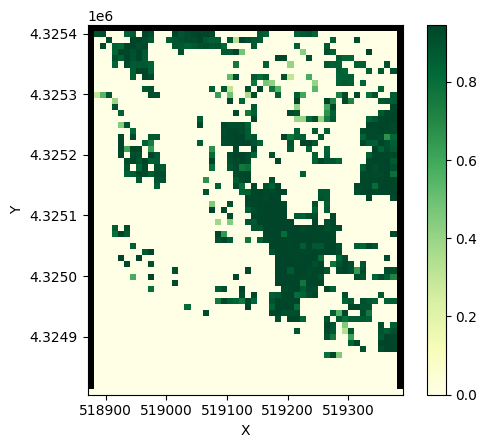

Vegetation map after last step


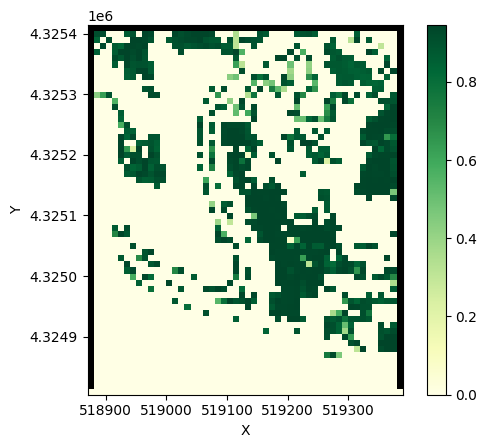

Elevation map after last step


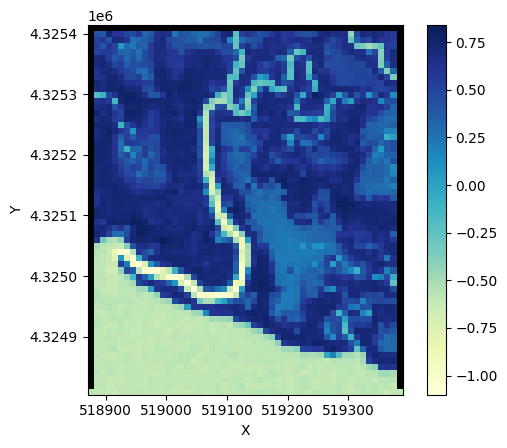

The MSL at the end of the model run was -0.08599999989041092


In [8]:
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.pyplot as plt

mev = pymm2d(grid, model_domain=model_domain, boundaryValues = boundaryTopo, runMEM=True)

versions = ['High', 'Medium', 'Low']

v = versions[1] # remember python starts counting from 0. For example 1 indicates the "Medium" model will be run.

# RUN the model #####################################################################################
print("Starting main loop")
for i in range(10):
    slr = 4 # USACE_SLR_Senarios(v, rnd = i)
    mev.run_one_step(timeStep = 1, round = i, model_domain = model_domain, relative_sea_level_rise_rate_mmPerYr = slr) # dt is a sea level rate modifier.
    grid.at_node["topographic__elevation"] = mev._elev
    if i == 0:
        testEle = (mev._elev)
        testVeg = (mev._vegetation)
print("Vegetation map after first step")
imshow_grid(grid, testVeg, cmap='YlGn')
plt.show()
print("Vegetation map after last step")
imshow_grid(grid, mev._vegetation, cmap='YlGn')
plt.show()
print("Elevation map after last step")
imshow_grid(grid, mev._elev, cmap='YlGnBu')
plt.show()


print(f'The MSL at the end of the model run was {mev._mean_sea_level}')